In [1]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pickle
from collections import Counter, defaultdict

import numpy
import pandas
from math import exp, sqrt, log

from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract, concatenate
from keras.callbacks import EarlyStopping

from sklearn.externals import joblib

from importlib import reload
from matplotlib import pyplot as plt
from random import random, shuffle, choice, randint

# from classes import Student, Question
# from utils import generate_student_name, create_qs, create_students, generate_attempts, calculate_pass_probability, attempt_q

import random
import math
import scipy

from NN_utils import BigTable, WeightClip

print("started")

from scipy.optimize import curve_fit
def gompertz(x, A,k1,k2,off):
    return A*numpy.exp(-k1*numpy.exp(-k2*(x-off)))

def inv_gompertz(y, A,k1,k2,off):
    return off + numpy.log(k1/numpy.log(A/y))/k2

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

# p = 1/(1+e(-x))
# 1+e(-x) = 1/p
# e(-x) = (1/p)-1
# x = -log((1/p)-1)

def inv_logistic(pr, b,off):
    return off-(numpy.log((1/pr) -1))/b

sigmoid = lambda z: 1/(1+(numpy.exp(-z)))
def pr(a,d): return sigmoid((a-d))
def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/comps)
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

def spread_to_pr(sp, comps=1):
    return numpy.power((1/(1+numpy.exp(-sp))), comps)

Using TensorFlow backend.


started


In [49]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_students(n_students, a0, a1, n_factors, gen_mode="truncnorm"):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
        true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c
    return students

def gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode="truncnorm", test_w=None):
    #approximate the min and max outputs from the gaussian
    boost = 4
    inv_fn = spread_to_pr
    av_c = (min_active_traits + max_active_traits)/2
    p = numpy.linspace(0.001,0.999,30)
    sprd = pr_to_spread(p, av_c, as_A_and_D=False)
    p2 = spread_to_pr(sprd, av_c)
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
#     d99 = pr_to_spread(.999, av_c, as_A_and_D=False)
#     d00 = pr_to_spread(.001, av_c, as_A_and_D=False)
#     print("dvals", d00, d50, d99)
    print("inv_logistic curve")
    plt.scatter(sprd,p)
    plt.plot(sprd,p2)
    plt.show()
#     print("tru spread d50=",d50, "(prob={})".format(spread_to_pr(d50, av_c)))
    
    minval = math.inf
    
    questions = numpy.zeros((n_questions, n_factors))
    questions = questions - 5
    for qix in range(n_questions):
        n_comps = random_integers(min_active_traits, max_active_traits)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
                
        if test_w:
            minb=-(test_w/2) - d50
            maxb=(test_w/2) - d50
        else:
            minb=0
            maxb=4
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)

        minval = 0

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
            
    return questions, minval

# minb,maxb,mina,maxa =(1.0, 11, 6, 11)
def gen_run(n_traits, a0, a1, min_active_traits, max_active_traits, s_gen="uniform", q_gen="uniform", test_w=None):
    questions, offset = gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode=q_gen, test_w=test_w)
    students = gen_students(n_students, 0, a1, n_factors, gen_mode=s_gen)

#     questions[questions>0] = questions[questions>0] - offset+1
#     students = students - offset+1
#     students = students

    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
#             zmask = (questions[mi] < 0.001).astype(int)
            diffs = students[vi]-questions[mi]
            prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
#             print(vi,mi, numpy.prod(prs))
    return obs, probs, students, questions

from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
# def generate_qs_model(qn_table, psi_table, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
# #     ob = Input(shape=(1,), name="observation")
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

#     psi_table.trainable=s_train
#     qn_table.trainable=q_train
    
#     qn_row = qn_table(qn_sel)
#     klip = Lambda(lambda q: K.clip(q,0,0.001))
#     q_masque = klip(qn_row)
    
# #     qn_row = GaussianNoise(.5)(qn_row)
#     psi_row = psi_table(psi_sel)
# #     psi_row = GaussianNoise(0.5)(psi_row)
    
#     difs = subtract([psi_row, qn_row])

    
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
#     Prs = Lambda(lambda ps_q:  ps_q[0]*1000*ps_q[1] + (1-1000*ps_q[1]) ) ([Prs, q_masque])
# #     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0], ps_q[1]) ) ([Prs, q_masque])
#     score = Lambda(lambda ps: K.prod(ps, keepdims=True, axis=1), name="score")(Prs)
        
# # score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
# #     score = Prs
    
# #     L_2a = Lambda(lambda w: K.mean(K.abs(K.zeros_like(w)-w)))
# #     mag_loss = (L_2a(qn_table.kernel) + sumstack)
    
# #     five_limit = Lambda(lambda w: K.mean(K.clip(K.sum(K.clip(w,0,1), axis=1),5,math.inf)-5))
# #     one_limit = Lambda(lambda w: K.mean(1-K.clip(K.max(w,axis=1),0,1)))
    
# #     L_2 = Lambda(lambda w: K.mean(K.square(w - 6 )))
# #     mag_loss = L_2(psi_table.kernel)
    
# #     shift_loss = Lambda(lambda k: K.mean(k))(psi_table.kernel)
    
# #     five_loss = five_limit(qn_table.kernel)
# #     one_loss = one_limit(qn_table.kernel)
# # #     mag_loss = L_2a(qn_table.kernel) + five_limit(qn_table.kernel) + one_limit(qn_table.kernel)*5
# #     mag_loss = L_2a(qn_table.kernel) #+ five_loss + one_loss
# # #     mag_loss = L_2(qn_row)
    
# #     def ident_loss(outer):
# #         def inner(t,h):
# #             return outer
# #         return inner

# #     def custom_loss(mag_loss):
# #         def orig_loss(yt,yh):
# # #             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
# # #             if comp_lims:
# #             return K.mean(K.square(yt-yh)) + mag_loss #+mag_loss # (reg_loss+mag_loss)/2
# # #                 return K.binary_crossentropy(yt,yh)
# # #             else:
# # # #                 return K.mean(K.square(yt-yh))
# # #                 return K.binary_crossentropy(yt,yh)
# #         return orig_loss
    
#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
# #     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
#     print(model.summary())
#     return model



# def generate_emb_model(qn_emb, psi_emb, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     qn_row = qn_emb(qn_sel)
#     psi_row = psi_emb(psi_sel)
# #     q_masque = q_gates(qn_sel)
    
# #     klip = Lambda(lambda q: K.clip(q,0,1e-3))
# #     q_masque = klip(qn_row)
#     difs = subtract([psi_row, qn_row])
#     Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
# #     Prs = Lambda(lambda ps_q:  ps_q[0]*1e3*ps_q[1] + (1-1e3*ps_q[1]) ) ([Prs, q_masque])
# #     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0],ps_q[1])) ([Prs, q_masque])
#     score = Lambda(lambda ps: K.prod(ps, keepdims=False, axis=2), name="score")(Prs)

#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
#     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
# #     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
#     print(model.summary())
#     return model






def check_object_invariance(students, questions, probs):
    all_ok = True
    false_ixs = []
    for six,srow in enumerate(students):
        for iix, qrow1 in enumerate(questions):
            for jix, qrow2 in enumerate(questions):
                spd_si = srow - qrow1
                spd_sj = srow - qrow2
                p_si_1 = probs[six,iix] #logistic(spd_si, 1,0)
                p_si_0 = (1 - p_si_1)
                p_sj_1 = probs[six,jix] #logistic(spd_sj, 1,0)
                p_sj_0 = (1 - p_sj_1)
#                 print(round(float((p_si_1 * p_sj_0)/(p_si_0 * p_sj_1)),5),"=?",round(math.exp(qrow2 - qrow1),5))
                istrue = (numpy.isclose((p_si_1 * p_sj_0)/float(p_si_0 * p_sj_1), math.exp(qrow2 - qrow1)))
#                 print(istrue)
                if not istrue:
                    all_ok=False
                    false_ixs.append((srow, qrow1, qrow2))
    return all_ok, false_ixs
# all_ok, fixs = check_object_invariance(students, questions, probz)
# print(all_ok)
# print(fixs)

def varinfo(X,Y):
    """X : set of sets representing partition 1
       Y : set of sets representing partition 2
    """
    VI = 0
    n = len(numpy.array(X).flatten())
    m = len(numpy.array(Y).flatten())
    if n!=m:
        raise ValueError("Size of set X does not match size of Y")
    for Xi in X:
        for Yj in Y:
            r_ij = len(set(Xi).intersection(Yj))/n
            if r_ij >0:
                p_i = len(Xi)/n
                q_j = len(Yj)/n
#                 print(p_i, q_j, r_ij)
#             {\displaystyle \mathrm {VI} (X;Y)=-\sum _{i,j}r_{ij}\left[\log(r_{ij}/p_{i})+\log(r_{ij}/q_{j})\right]}.
#                 print("log1",numpy.log(r_ij/p_i),"log2", numpy.log(r_ij/q_j))
                VI += r_ij*(numpy.log(r_ij/p_i) + numpy.log(r_ij/q_j))
#                 print("VI subtot", VI)
    VI = -VI
    return VI

In [3]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
def generate_bayesian_model(qn_table, psi_table, optimiser, comp_lims=True):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    psi_row = psi_table(psi_sel)
    qn_row = qn_table(qn_sel)

#     klip = Lambda(lambda q: K.clip(q,0,1))
#     q_masque = klip(qn_row)

    Prs = Lambda(lambda sq: (1-sq[1])+(sq[1]*sq[0]), name="bayes_step")([psi_row, qn_row])
    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
#     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])

    print(model.summary())

    return model

In [1]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout
from keras import backend as K
from keras.optimizers import Adam
def generate_qs_model(qn_table, psi_table, optimiser, comp_lims=True, test_av=0):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    psi_row = psi_table(psi_sel)
    qn_row = qn_table(qn_sel)
    
#     shift_loss = Lambda(lambda q : K.square(K.mean(q)- 5) )(qn_row)

    klip = Lambda(lambda qk: K.clip(qk,0, .1))
    q_masque = klip(qn_row)

#     qn_row = GaussianNoise(.5)(qn_row)
#     psi_row = GaussianNoise(0.5)(psi_row)
#     prds = multiply([qn_row, psi_row])
    difs = subtract([psi_row, qn_row])
#     score = Lambda(lambda ps: K.sum(ps, axis=1, keepdims=True)/n_factors, name="score")(prds)
    Prs = Lambda(lambda z: (K.exp(z) / (1.0 + K.exp(z))), name="Pr_sigmoid1")(difs)
#     Prs = Lambda(lambda ps_q:  ps_q[0]*10*ps_q[1] + (1.0-10*ps_q[1]) ) ([Prs, q_masque])
#     Prs = Lambda(lambda ps_q:  K.pow(ps_q[0], 100*ps_q[1]) ) ([Prs, q_masque])

    score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    
    l2 = Lambda(lambda t: K.sum(K.square(t - 0)))(qn_table.kernel)
    
#     L_2a = Lambda(lambda w: K.mean(K.abs(K.zeros_like(w)-w)))
#     mag_loss = (L_2a(qn_table.kernel) + sumstack)
    
#     five_limit = Lambda(lambda w: K.mean(K.clip(K.sum(K.clip(w,0,1), axis=1),5,math.inf)))
#     one_limit = Lambda(lambda w: K.mean(1-K.clip(K.max(w,axis=1),0,1)))
    
#     five_loss = 10*five_limit(qn_row)#(qn_table.kernel)
#     one_loss = one_limit(qn_row)#(qn_table.kernel)
#     mag_loss = L_2a(qn_table.kernel) #+ five_limit(qn_table.kernel) + one_limit(qn_table.kernel)*5
#     mag_loss = five_loss + one_loss
#     mag_loss = L_2(qn_row)
    
#     def ident_loss(outer):
#         def inner(t,h):
#             return outer
#         return inner
      
    def custom_loss(aux_loss):
        def orig_loss(yt,yh):
            return K.binary_crossentropy(yt,yh) + aux_loss #+mag_loss # (reg_loss+mag_loss)/2
#             return K.mean(K.square(yt-yh)) + aux_loss#/10000 #+mag_loss # (reg_loss+mag_loss)/2
        return orig_loss
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
#     model.compile(optimizer=optimiser, loss=custom_loss(shift_loss), metrics=["accuracy"])

    print(model.summary())

    return model

Using TensorFlow backend.


In [5]:
# def generate_params(max_active, min_active):    
#     s_avg_intel = numpy.random.uniform(-1, 1, size=1) 
#     q_av_c = (min_active + max_active)/2
#     cprod_offset = pr_to_spread(0.5, comps=q_av_c, as_A_and_D=False)
#     s_sd = numpy.random.uniform(0.1, .66)
    
# #     s_avg_intel = numpy.random.uniform(0, 3, size=1)  
# #     s_approx_min = s_avg_intel - 3*s_sd        
#     a0 = s_avg_intel + cprod_offset
        
# #     test_w = numpy.random.uniform(0.5, 4)
# #     test_centre = q_active_min + test_w/2
# #     print("base",base)
# #     a0 = offset + base
#     test_w = 1 #numpy.random.uniform(0.5, 4)
#     return s_sd,a0,q_av_c,cprod_offset,test_w

def generate_params(max_active, min_active):    
    s_avg_intel = 0
#     s_avg_intel = numpy.random.uniform(-2, 2, size=1)  
    q_av_c = (min_active + max_active)/2
    cprod_offset = pr_to_spread(0.5, comps=q_av_c, as_A_and_D=False)
    s_sd = 1
    
#     s_approx_min = s_avg_intel - 3*s_sd        
    a0 = s_avg_intel + cprod_offset
        
#     test_w = numpy.random.uniform(0.5, 4)
#     test_centre = q_active_min + test_w/2
#     print("base",base)
#     a0 = offset + base
    test_w = 2.5 
#     test_w = numpy.random.uniform(0.5, 4)
    return s_sd,a0,q_av_c,cprod_offset,test_w

inv_logistic curve


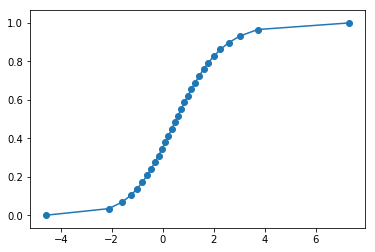

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead


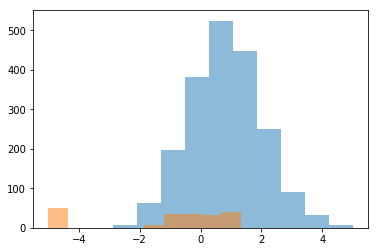

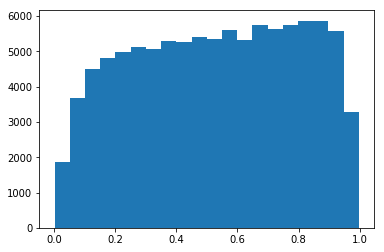

(1000, 100)
1000 100
100000 52929.0
0.52929
[ 0.04532561  0.04046385  0.03225633 ...,  0.04435071  0.04419017
  0.04570787]
--- -
[ 0.95040404  0.96624788  0.95157434 ...,  0.95900059  0.96144861
  0.95693222]


In [6]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
# n_factors, a0, a1, min_active, max_active = (1, 0, 0.33, 1, 1)
# n_students = 100
# n_questions = 25

n_factors, min_active, max_active = (2,1,2)
n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 0.8110750422323121, 1.1967074599870124, 0.53204746933021974, 2.6389781733222257)

# n_factors, min_active, max_active = (10, 1, 5)
# n_students, n_questions, a0, a1, offset, test_w =(1000, 100, 1.0451284704587152, 1.4855458602659655, 0.53204746933021974, 2.0764586353304395)

# res =gen_run(n_factors, n_students, n_questions, a0, sda, min_active, max_active, None,None)
obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)
# print(len(res))

plt.hist(students.flatten(), alpha=0.5)
# plt.show()
plt.hist(questions.flatten(), alpha=0.5)
plt.show()
# print(numpy.mean(questions[questions>0]))

plt.hist(probz.flatten(), bins=20)

plt.show()

print(probz.shape)
print(len(students), len(questions))

print(len(obs.flatten()), sum(obs.flatten()))
print(sum(obs.flatten())/len(obs.flatten()))

print(probz[probz<0.05])
print("--- -")
print(probz[probz>0.95])



0.53204746933 1
inv_logistic curve


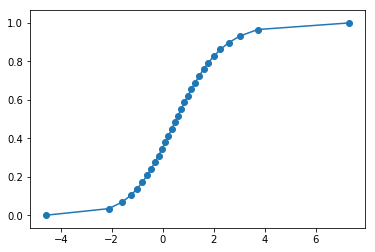

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead


~ ~ ~ ~~ ATTEMPT 0


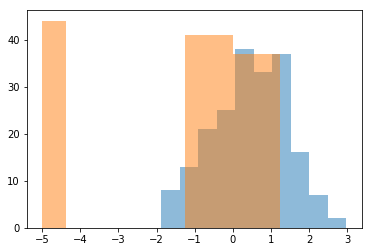

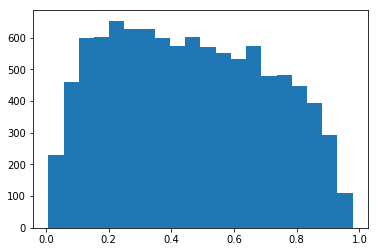

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


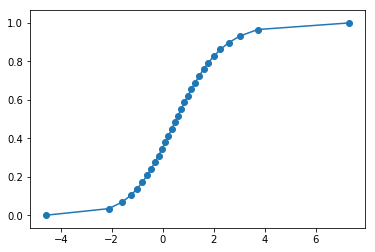

~ ~ ~ ~~ ATTEMPT 1


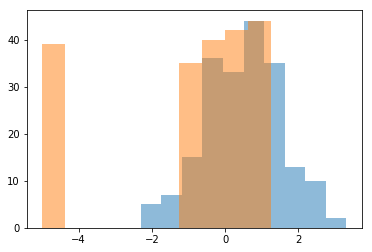

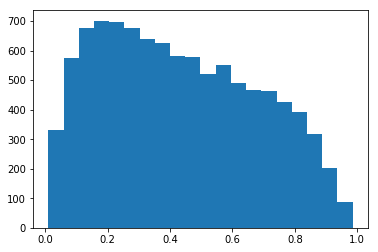

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


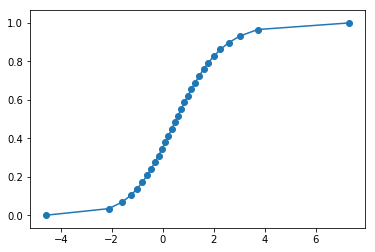

~ ~ ~ ~~ ATTEMPT 2


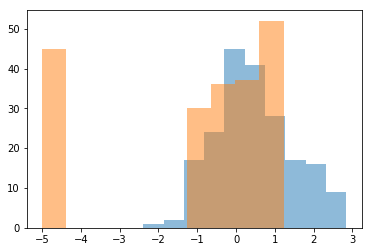

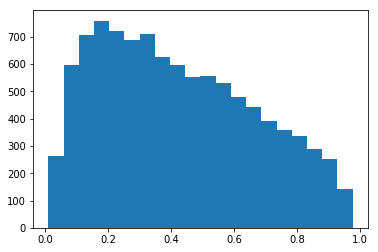

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


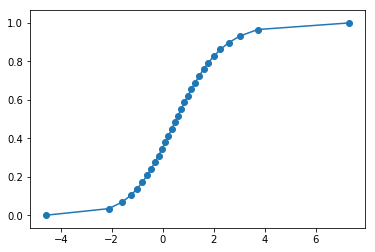

~ ~ ~ ~~ ATTEMPT 3


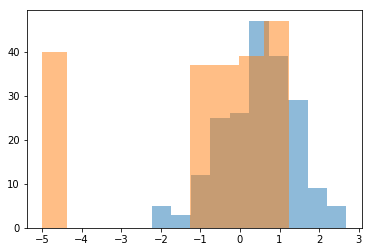

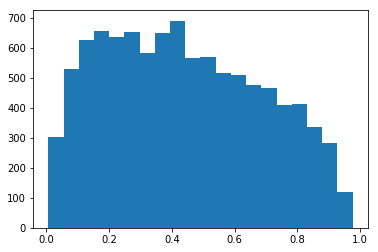

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


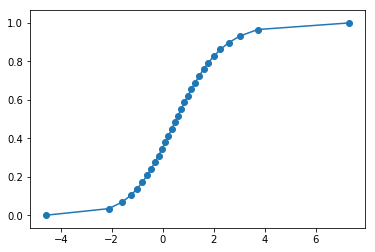

~ ~ ~ ~~ ATTEMPT 4


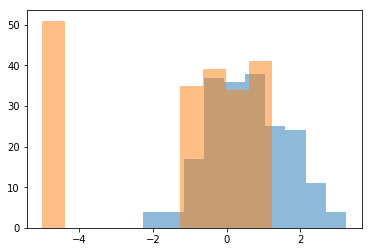

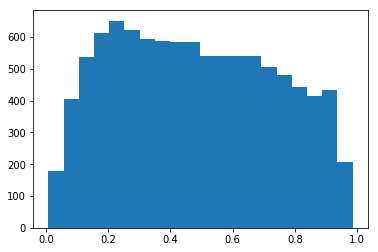

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


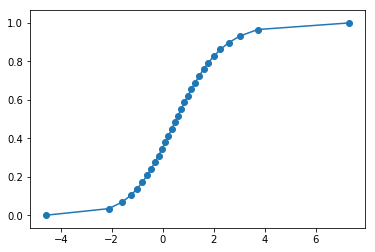

~ ~ ~ ~~ ATTEMPT 5


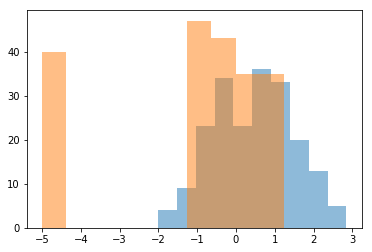

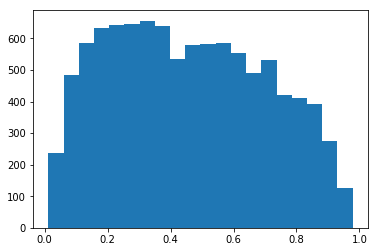

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


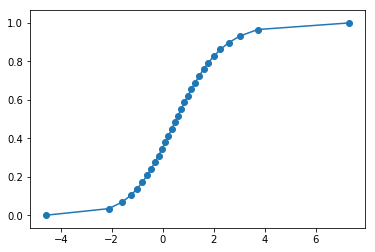

~ ~ ~ ~~ ATTEMPT 6


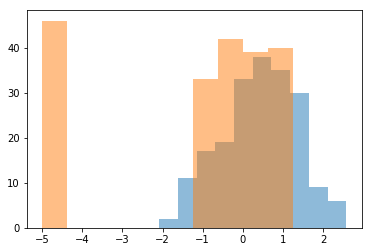

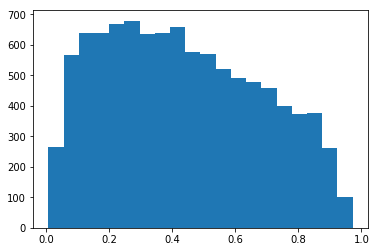

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


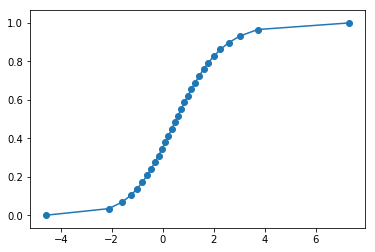

~ ~ ~ ~~ ATTEMPT 7


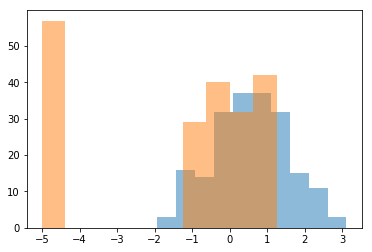

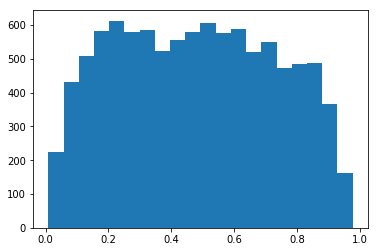

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


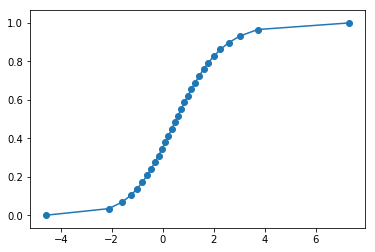

~ ~ ~ ~~ ATTEMPT 8


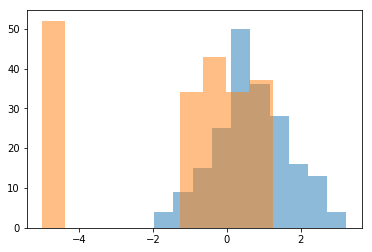

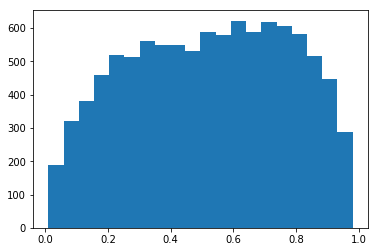

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)
0.53204746933 1
inv_logistic curve


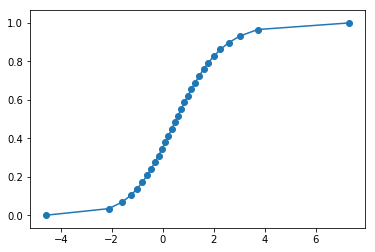

~ ~ ~ ~~ ATTEMPT 9


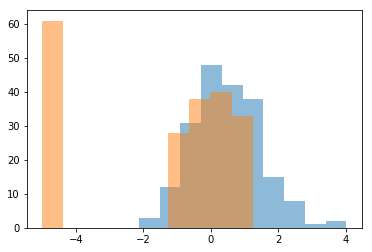

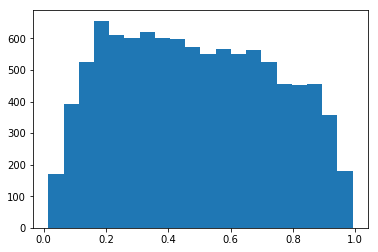

2 FACTORS
100 STUDENTS: 0.5320474693302197 1
100 QUEST/NS: 2.5
Offset 0.53204746933
(100, 100, 0.5320474693302197, 1.0, 0.53204746933021974, 2.5)


In [7]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
n_factors, min_active, max_active = (2,1,2)

for a in range(10):
    n_students = 100 # int(10**(scipy.stats.truncnorm.rvs(2,4, size=1)))
    n_questions = 100 # int(numpy.random.uniform(15,35, size=1))
    a1,a0,av_c,offset,test_w = generate_params(max_active, min_active)
    print(a0, a1)
    obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)

    print("~ ~ ~ ~~ ATTEMPT",a)
    plt.hist(students.flatten(), alpha=0.5)
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
    plt.hist(probz.flatten(), bins=20)
    plt.show()
    print("{} FACTORS".format(n_factors))
    print("{} STUDENTS: {} {}".format(n_students, a0, a1))
    print("{} QUEST/NS: {}".format(n_questions, test_w))
    print("Offset", offset)
    print((n_students, n_questions, float(a0), float(a1), offset, test_w))

In [ ]:
# for orow in obs:
#     srow = map(str, map(int, list(orow)))
#     srow = "".join(srow)
#     print(srow)

In [ ]:
# students = gen_students(100, 9, 1, 100)
# questions, minval = gen_questions(100, 9, 1, 1,5, gen_mode="uniform")
# # plt.hist(questions.flatten())
# print(minval)
# q2 = questions
# q2[q2>0] = q2[q2>0] - minval +6
# s2 = students - minval +6
# plt.hist(q2.flatten(), alpha=0.5)
# plt.hist(s2.flatten(), alpha=0.5)

# plt.show()

In [ ]:
# from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, dot
# from keras import backend as K
# from keras.optimizers import Adam
# def generate_mxf_model(qn_table, psi_table, optimiser, comp_lims=True, q_train=True, s_train=True):
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
# #     ob = Input(shape=(1,), name="observation")
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

#     psi_table.trainable=s_train
#     qn_table.trainable=q_train
    
#     qn_row = qn_table(qn_sel)
#     psi_row = psi_table(psi_sel)
#     score = dot([psi_row, qn_row], axes=1)
    
#     mag_loss=0
    
#     def custom_loss(mag_loss):
#         def orig_loss(yt,yh):
# #             return K.binary_crossentropy(yt,yh) + mag_loss/100000 #+mag_loss # (reg_loss+mag_loss)/2
# #             if comp_lims:
#             return K.mean(K.square(yt-yh)) #+ mag_loss #+mag_loss # (reg_loss+mag_loss)/2
# #                 return K.binary_crossentropy(yt,yh) #+ mag_loss/1000 #+mag_loss # (reg_loss+mag_loss)/2
# #             else:
# # #                 return K.mean(K.square(yt-yh))
# #                 return K.binary_crossentropy(yt,yh)
#         return orig_loss
    
#     model = Model(inputs=[qn_sel, psi_sel], outputs=score)
# #     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
# #     if comp_lims:
#     model.compile(optimizer=optimiser, loss=custom_loss(mag_loss), metrics=["accuracy"])# metrics=[ident_loss(five_loss), ident_loss(one_loss),"accuracy"])
# #     else:
# #     model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
        
#     print(model.summary())

#     return model

In [ ]:
# from collections import defaultdict

# frak = 1
# pairs_to_use = [(v,m) for v in range(n_students) for m in range(n_questions)]
# seenkeys = []
# seen = defaultdict(list)

# av_c=n_factors
# inv_sigmoid = lambda p: -numpy.log(1/p - 1)
# p50 = inv_sigmoid( 0.5**(1/av_c) )
# print("p50 is ", p50, "for comps", av_c)

# smin = min(students.flatten())
# smax = max(students.flatten())
# qmin = min(questions.flatten())
# qmax = max(questions.flatten())
# students = students - smin
# questions = questions - smin


# smin = min(students.flatten())
# smax = max(students.flatten())
# qmin = min(questions.flatten())
# qmax = max(questions.flatten())
# print(smin, smax, "s/q", qmin, qmax)


# w=n_factors
# # s_table =  BigTable((n_students, w), 0, 20, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
# # qn_table = BigTable((n_questions, w), 0, 20, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
# # qn_table = BigTable((n_questions, w), 0, 20, init_hilo=0)#, regulariser=regularizers.l1(10e-6))

# # s_table =  BigTable((n_students, w), 0, 12, init_hilo=6)#, regulariser=regularizers.l2(10e-6))
# # # qn_table = BigTable((n_questions, w), 0, 10, init_hilo=5-p50)#, regulariser=regularizers.l1(10e-6))
# # qn_table = BigTable((n_questions, w), 0, 12, init_hilo=6-p50)#, regulariser=regularizers.l1(10e-6))


In [ ]:
# print(len(students))
# print(len(questions))

In [32]:
def tvt_split(sws, qws, split_mode=3):
    all_sz = []
    all_qz = []
    all_pfz = []
    sig = lambda z : 1/(1+numpy.exp(-z))
    obs = numpy.zeros((len(sws), len(qws)))
    probs = numpy.zeros((len(sws), len(qws)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    all_pfz=[]
    all_pairs = set()
    attempt_lookup = defaultdict(list)
    cts=[]
    for vi in range(len(sws)):
        for mi in range(len(qws)):
            for _ in range(1):
                all_pairs.add((vi,mi))
#                 zmask = (qws[mi]==-10).astype(int)
                deltas = sws[vi]-qws[mi]
                prs = logistic(deltas,1,0)
#                 prs = numpy.maximum(zmask,prs)

                pr = numpy.prod(prs)
                ct=0

                all_sz.append(vi)
                all_qz.append(mi)

                rd = random.random()
#                     print(vi, mi, pr, rd)
                ob = (rd < pr)
#                 obs[vi,mi] = ob
                probs[vi,mi] = pr
#                 all_pfz.append(pr)
                attempt_lookup[(vi,mi)].append(ob)
    #             print(vi,mi, numpy.prod(prs))

    print("len all_pfz", len(all_pfz))
    plt.hist(all_pfz)
    plt.show()

    plt.hist(probs.flatten())
    plt.show()
    
    plt.hist(cts, range=[0,10])
    plt.show()

    print("OBS SSHAPE", obs.shape)

    frak=1
    all_pair_ixs = list(range(len(all_pairs)))
    # ixs_to_use = numpy.random.choice(all_pair_ixs, size=int(max(frak*len(all_pairs),10)), replace=True)
    # pairs_to_use = numpy.array(all_pairs)[ixs_to_use]

    all_ixs = all_pair_ixs
    
    val_ixs = numpy.random.choice(all_pair_ixs, size=1000, replace=False) #len(attempts)//100, replace=False)
    trn_ixs = list(set(all_ixs) - set(val_ixs))
    test_ixs = numpy.random.choice(trn_ixs, size=1000, replace=False) #len(attempts)//100, replace=False)
    trn_ixs = list(set(trn_ixs) - set(test_ixs))
    print("tvt:", len(all_ixs), len(trn_ixs), len(test_ixs))

#     all_sz = numpy.array(all_sz).reshape([-1,1])
#     all_qz = numpy.array(all_qz).reshape([-1,1])
#     all_pfz = numpy.array(all_pfz).reshape([-1,1])
#     print("len all_pfz", len(all_pfz))

    all_pairs = sorted(list(all_pairs))
    test_pairs = [all_pairs[ix] for ix in test_ixs]
    val_pairs = [all_pairs[ix] for ix in val_ixs]
    train_pairs = [all_pairs[ix] for ix in trn_ixs]
    
    tsz=[]
    tqz=[]
    tpfz=[]
    
    vsz=[]
    vqz=[]
    vpfz=[]
    
    sz=[]
    qz=[]
    pfz=[]
    
    for tp in test_pairs:
        scores = attempt_lookup[tp]
        for sc in scores:
            tsz.append(tp[0])
            tqz.append(tp[1])
            tpfz.append(sc)
    
    if split_mode==2:
        train_pairs = train_pairs + val_pairs
        val_pairs = []
    
    if split_mode==1:
        train_pairs = train_pairs + val_pairs + test_pairs
        test_pairs = []
        val_pairs = []
    
    for tp in val_pairs:
        scores = attempt_lookup[tp]
        for sc in scores:
            vsz.append(tp[0])
            vqz.append(tp[1])
            vpfz.append(sc)

    for tp in train_pairs:
        scores = attempt_lookup[tp]
        for sc in scores:
            sz.append(tp[0])
            qz.append(tp[1])
            pfz.append(sc)

    tsz=numpy.array(tsz)
    tqz=numpy.array(tqz)
    tpfz=numpy.array(tpfz)
    
    vsz=numpy.array(vsz)
    vqz=numpy.array(vqz)
    vpfz=numpy.array(vpfz)
    
    sz=numpy.array(sz)
    qz=numpy.array(qz)
    pfz=numpy.array(pfz)
    
    return (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz), obs, probs

In [ ]:
(sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz), obs, probs = tvt_split(students, questions)
print(vpfz)

In [ ]:
# print(obs.shape)
# rho_mx = numpy.corrcoef(obs.T, obs.T)
# print(rho_mx)
# print(rho_mx.shape)

In [ ]:
# import sklearn
# rho_mx2 = sklearn.metrics.pairwise.cosine_similarity(obs.T,obs.T)
# numpy.set_printoptions(threshold=100)
# print(rho_mx2)
# print(rho_mx2.shape)

In [ ]:
# user_index = 500 # The id of the user for whom we want to generate recommendations

# # magnitude = numpy.sqrt(numpy.square(obs).sum(axis=1))

# # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
# # data_items = obs / magnitude.reshape(-1,1)
# data_items = obs

# # Get the artists the user has likd.
# for user_index in range(len(students)):
#     known_user_likes = data_items[user_index,:]
# #     print(known_user_likes)
#     # known_user_likes = known_user_likes[known_user_likes >0].index.values
#     # known_user_likes = numpy.argwhere(known_user_likes)

# #     print(rho_mx2.sum(axis=0))

#     # Calculate the score.
# #     score = rho_mx2.dot(known_user_likes) / (rho_mx2.sum(axis=0))

#     for i in range(len(questions)):
#         sum_nom=0
#         sum_denom=0
#         wi = rho_mx2[i]
#         rui = data_items[user_index, i]
#         for j in range(len(questions)):
#             wij = wi[j]
#             sum_nom += wij*rui
#             sum_denom += abs(wij)
#         score = sum_nom/sum_denom
#         numpy.set_printoptions(precision=5)
#         print(user_index, i, score)
# #         print(students[user_index])
#     # Remove the known likes from the recommendation.
#     # score = numpy.delete(score, known_user_likes)

#     # Print the known likes and the top 20 recommendations.

#     # print (score.argsort()[::-1][:20])
    

In [ ]:
# for ix in range(len(qws)):
#     flags = (qws[ix]>1).astype(int) 
#     print(flags, sum(flags))
# # print((qws>=1).astype(int))

In [ ]:
numpy.set_printoptions(precision=2)
for vi,mi,sc in zip(sz,qz,pfz):
    print(vi,mi,sc)

In [ ]:
print("TRUE VALS")
# print(numpy.min(questions), numpy.min(questions[questions.nonzero()]), numpy.max(questions))
print(numpy.min(questions), numpy.max(questions))
print(numpy.min(students), numpy.max(students))
print("--- EMB VALS (prior):")
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
# print(numpy.min(qws), numpy.min(qws[qws>=1]), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(qws), numpy.max(qn_table.get_weights()[0]))
print(numpy.min(s_table.get_weights()[0]), numpy.max(s_table.get_weights()[0]))


# print(qws)

In [ ]:
print(qz)

preds = m.predict(x=[qz,sz])
for sc_true, sc_hat in zip(pfz[0:100],preds[0:100]):
    print(sc_true, sc_hat)

# print(m.evaluate(x=[mz,vz], y=scz))
from sklearn.metrics import accuracy_score, mean_absolute_error
print(accuracy_score(numpy.around(pfz), numpy.around(preds)  ))

s_scores = defaultdict(list)

for six in range(len(students)):
    scs = m.predict(x=[numpy.array(range(len(questions))).reshape(-1,1), numpy.array(six).repeat(len(questions))])
    s_scores[six].extend(scs)

for six in range(len(students)):
    s_av = float(numpy.median(s_scores[six]))
    print(six, s_av)


In [54]:
# wz = m.get_weights()
# s_table =  BigTable((n_students, n_factors), 6, 100, init_hilo=10)#, regulariser=regularizers.l1(10e-6))
# qn_table = BigTable((n_questions, n_factors), 0, 100, init_hilo=10-p50)#, regulariser=regularizers.l1(10e-6))
# qm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=False, q_train=True)
# sm = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, s_train=True, q_train=False)
from keras import regularizers
def generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=n_factors, test_av=a0):
    weight_mode="semi-free"
#     weight_mode="bayesian"
# #     numpy.random.seed(666)
    if weight_mode=="free":
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo=0)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo=0)#, regulariser=regularizers.l1(10e-6))
    elif weight_mode=="semi-free":
        s_table =  BigTable((n_students, w), -10, 10, init_hilo=0)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -5, 10, init_hilo=0)#, regulariser=regularizers.l1(1e-6))
    elif weight_mode=="bayesian":
        s_table =  BigTable((n_students, w), 0, 1, init_hilo=0.5)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0, 1, init_hilo=0.5)#, regulariser=regularizers.l1(1e-6))
    else:
        s_table =  BigTable((n_students, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0, 12, init_hilo=0)#, regulariser=regularizers.l1(10e-6))
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
    q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    m = generate_qs_model(qn_table, s_table, Adam(), comp_lims=False, test_av=test_av)#, s_train=True, q_train=True)
    if vqz:
        lozz="loss"
    else:
        lozz="val_loss"
    es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
    h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=1000, shuffle=True, epochs=100000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, q_gates, m, h

In [ ]:
s_table, qn_table, _, m, h = generate_and_train(qz,sz,pfz, vqz,vsz,vpfz, w=n_factors)

In [ ]:
for six in range(len(students)):
    print("S=",six)
    scs = m.predict(x=[numpy.array(range(len(questions))).reshape(-1,1), numpy.array(six).repeat(len(questions))])
    for qix in range(len(questions)):
        print(qix, " : ", scs[qix], obs[six,qix], probs[six,qix])
#     s_scores[six].extend(scs)

# for six in range(len(students)):
#     s_av = float(numpy.median(s_scores[six]))
#     print(six, s_av)
    
    
    

In [ ]:
def plot_history(history):
    plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('MSE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(h)

In [ ]:
right_ct=0
# preds = m.predict(x=[qz,sz])
# for q,s, sc_obsv, sc_hat in zip(qz,sz,pfz,preds):
#     print(q,s, sc_obsv, sc_hat, "right" if (numpy.around(sc_obsv)==numpy.around(sc_hat)) else "X")

print(len(pfz), len(tpfz))
right_ct=0
preds = m.predict(x=[tqz,tsz]).flatten()
print(preds)
# flags = numpy.random.random(size=len(preds))
# print(flags)
# preds = flags <= preds
ground_truths = []
zipd_list = sorted(list(zip(tsz, tqz,tpfz,preds)))
for s,q, sc_obsv, sc_hat in zipd_list:
#     sc_hat_stoc = (random.random() < sc_hat)
    pr = probs[s,q]
    print(q,s, sc_obsv, pr, sc_hat, "right" if (numpy.around(pr)==numpy.around(sc_hat)) else "X")
    ground_truths.append((pr,sc_hat))
#     print(sc_obsv, sc_hat, res)

# print(m.evaluate(x=[tmz,tvz], y=tscz))

from sklearn.metrics import accuracy_score, mean_absolute_error
print(preds.shape)

# print(right_ct / len(tpfz))

print("#########")
for (g,p) in ground_truths:
    print(g,p)

print("obvsd acc", accuracy_score(numpy.around([g[0] for g in ground_truths]), numpy.around([g[1] for g in ground_truths])))
# print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
# print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
for qix in range(len(questions)):
    kcs = numpy.argwhere(questions[qix] > 1)
    
    klevs = questions[qix][kcs.flatten()] 
    print(qix, ["{}={}".format(k,round(klev,2)) for (k,klev) in zip(kcs.flatten(),klevs)])

In [ ]:
qws = qn_table.get_weights()[0]
sws = s_table.get_weights()[0]
# qmin = min(qws)

offset = numpy.mean(students) - numpy.mean(sws) 
qws = qws #+ offset
sws = sws #S+ offset
print(len(qws.flatten()))
print(len(questions.flatten()))
item_RMSE = numpy.sqrt(numpy.mean(numpy.square(numpy.sort(qws.flatten()) - numpy.sort(questions.flatten()))))
item_MAE = numpy.mean(numpy.abs(numpy.sort(qws.flatten()) - numpy.sort(questions.flatten())))
# item_RMSE = numpy.sqrt(numpy.mean(numpy.square(qws.flatten() - questions.flatten())))
# item_MAE = numpy.mean(numpy.abs(qws.flatten() - questions.flatten()))

print(item_RMSE, item_MAE)

In [ ]:
# preds = m.predict([tqz,tsz])
# for pred,q,s in zip(preds,tqz,tsz):
#     print(q, pred)
numpy.set_printoptions(precision=2)

seen = set()
for qix,six in zip(tqz, tsz):
    if (int(qix),int(six)) in seen:
        continue
    else:
        seen.add((int(qix),int(six)))
    qrow = questions[qix].flatten()
    srow = students[six].flatten()
    qhat = qws[qix].flatten()
    shat = sws[six].flatten()
#     print(qix, six, (srow, shat), (qrow, qhat), srow-qrow, shat-qhat)
    print("STUDENT", six)
    print(srow)
    print(shat)
    print("VS Q", qix)
    print(qrow)
    print(qhat)#, " >>>", srow-qrow, shat-qhat)
    print("Comp. Prs:")
    for s,q in ((srow,qrow), (shat,qhat)):
        zmask = (q<0.0001).astype(int)
        deltas = s-q
        prs = logistic(deltas,1,0)
        prs = numpy.maximum(zmask,prs)
        print(prs, numpy.prod(prs))
    
print(len(sws))
print(len(students))

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

plt.hist(students.flatten(), alpha=0.5, bins=bin_spread(students))
plt.hist(sws[list(set(tsz))].flatten(), alpha=0.4, bins=bin_spread(sws))
plt.show()
plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
print(bin_spread(qws))
plt.hist(qws[list(set(tqz))].flatten(), alpha=0.4, bins=bin_spread(qws))
plt.show()

In [2]:
import copy
# numpy.random.seed(666)
# n_students, n_questions, a0, a1, offset, test_w = (1000, 100, 0.8110750422323121, 1.1967074599870124, 0.53204746933021974, 2.6389781733222257)
n_students, n_questions = 100,100
n_factors, min_active, max_active = (10,1,5)
# n_factors, min_active, max_active = (2,1,2)
# n_students, n_questions, a0, a1, offset, test_w = (5000, 100, 0.6516427938897171, 1.5588438755755065, 0.53204746933021974, 0.7168318678096066)

qws_list = []
sws_list = []
tr_list = []
questions=None
stu_list=[]
n_runs = 4
tw=None
for _ in range(n_runs):
    a1,a0,av_c,offset,test_w = generate_params(min_active, max_active)
    if tw is None:
        tw=test_w
    _, _, students2, qz_temp  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = tw)
    stu_list.append(students2)
    if questions is None:
        questions = qz_temp
        
    print("~ ~ ~ ~~ ATTEMPT",a)
    plt.hist(students2.flatten(), alpha=0.5)
    plt.show()
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
        
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
    tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))

#     plt.hist(questions.flatten(), alpha=0.5)
#     plt.hist(students2.flatten(), alpha=0.5)    
#     plt.show()

    
# for runix in range(n_runs):
#     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
    s_table2, qn_table2, _, m2, h2 = generate_and_train(qz2,sz2,pfz2, vqz2,vsz2,vpfz2, w=n_factors, test_av=offset)
    qws2= copy.copy(qn_table2.get_weights()[0])
    sws2= copy.copy(s_table2.get_weights()[0])
#     qg = q_gates.get_weights()[0]
#     qg_list.append(qg)
    sws_list.append(sws2)
    qws_list.append(qws2)


NameError: name 'generate_params' is not defined

In [22]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


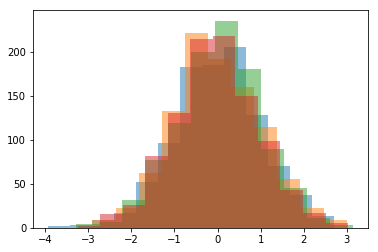

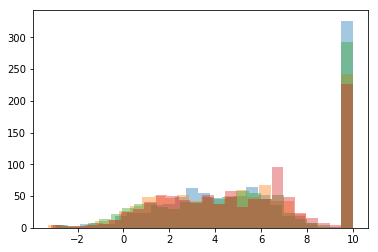

28
len qws_list 4
med -1.46432
med -1.92647
med -1.71206
med -1.71006


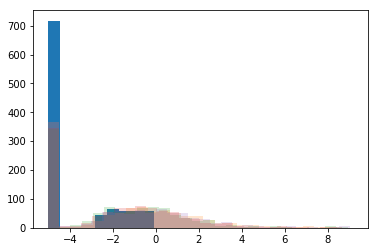

In [56]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in stu_list:
    plt.hist(ss.flatten(), alpha=0.5, bins=bin_spread(ss))
plt.show()

sw_av_list = []
for sw, tups in zip(sws_list, tr_list):
    (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.4, bins=bin_spread(sw))
    sw_av_list.append(numpy.median(sw.flatten()))
plt.show()
plt.hist(questions.flatten(), alpha=1, bins=bin_spread(questions))
print(bin_spread(qws2))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))
for qw, tups, av in zip(qws_list, tr_list, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw))
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw))

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, bins=bin_spread(qw))

plt.show()

# qws_list = qws_list2

In [ ]:
# s_offset = ((numpy.max(students, axis=0)-numpy.min(students, axis=0))/2 - (numpy.max(sws2, axis=0)- numpy.min(sws2, axis=0))/2)
# s_offset = (numpy.median(students, axis=0) - numpy.median(sws2, axis=0))
# s_offset = numpy.median(questions, axis=0) - numpy.median(qws2, axis=0)
# np_sws_list = numpy.array(sws_list)
# print(np_sws_list)

# # for sw in sws_list:
# s_offset = numpy.median(numpy.median(sws_list, axis=1), axis=0)
# s_sd = numpy.median(numpy.std(sws_list, axis=1), axis=0)
# print(s_offset, s_sd)

# s_offset = s_offset- 2.7*s_sd
# print(s_offset)
# q_offset = numpy.median(qw, axis=1)
# q_offset = numpy.median(q_offset, axis=0)
# # s_offset = numpy.median(s_offset, axis=0)
# # print(s_offset)
# print("\n",q_offset)

# for sw in sws_list:
# s_offset = numpy.min(sws_list, axis=1)
# print(s_offset)

# s_offset = numpy.median(numpy.min(sws_list, axis=1), axis=0)
# s_sd = numpy.median(numpy.std(sws_list, axis=1), axis=0)
# print(s_offset, s_sd)

qw_min_list = []
for qws in qws_list:
    qws[qws < -1] = numpy.nan
#     means = np.nanmean(data[:, 1:], axis=1)
    qwm=numpy.nanmedian(qws, axis=0)
    qw_min_list.append(qwm)
    qws[numpy.isnan(qws)] = 0
print(qw_min_list)
s_offset = qw_min_list

In [ ]:
import copy
def stats_about_stuff(real_items):
    cp = copy.copy(real_items)
    cp[cp==0]=numpy.nan
    meds = numpy.nanmedian(real_items, axis=0)
    meansnan = numpy.nanmean(cp, axis=0)
    medsnan = numpy.nanmedian(cp, axis=0)
    q_mx = (real_items>=(meds-5))#.astype(int)
#     print(cp)
    print(meds)
    print(medsnan)
    print(meansnan)
#     print(q_mx)
    for ix,it in enumerate(real_items):
        qrow = (it>0).astype(int)
        print(ix, qrow, sum(qrow), numpy.median(it[it>0]))#, numpy.linalg.norm(it[it>0]))

stats_about_stuff(questions)

In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1

In [ ]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    tx=None
#     tx = PCA(n_components=2)
#     tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = None
    for opreds in pred_list:
        preds = copy.copy(opreds) - s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
        itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        n = len(itemz_pred)
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
        itemz = real_items
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
        if itemz_2 is None:
            itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
        else:
            itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
        
        fig = plt.gcf()
        fig.set_size_inches(10, 10)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="k", zorder=10)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
                print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]
        
print(len(qws_list))
plot_items(qws_list, copy.copy(questions), s_offset)

In [ ]:
from sklearn.cluster import KMeans
km = KMeans()
q= questions
km.fit(q)
cluster_labels = km.predict(q)
print(cluster_labels)

fig = plt.gcf()
n = len(q)
fig.set_size_inches(10, 10)
fig.gca().scatter(q[0:n,0], q[0:n,1], alpha=0.7, c=cluster_labels, cmap=plt.get_cmap("Set1") )
for j in range(n):
    fig.gca().annotate(j, (q[j,0], q[j,1]))
# fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)

In [ ]:
# plot_items([qws2], questions)

In [ ]:
# n_factors, a0, a1, min_active, max_active = (5, 9, 1, 1, 3)
# n_factors, a0, a1, min_active, max_active = (100, 0, 1, 1, 5)
n_factors, min_active, max_active = (2, 1, 2)

for _ in range(100):
    n_students = int(10**(scipy.stats.truncnorm.rvs(2,4, size=1)))
    n_questions = int(numpy.random.uniform(15,35, size=1))
    a1 = numpy.random.uniform(1, 3.5, size=1)
    a0 = numpy.random.uniform(-0.5,1, size=1)
    av_c = (min_active + max_active)/2
    offset = pr_to_spread(0.5, comps=av_c, as_A_and_D=False)
    a0 = a0 + offset
    test_w = numpy.random.uniform(0.5, 3.5)
    print("{} FACTORS".format(n_factors))
    print("{} STUDENTS: {} {}".format(n_students, a0, a1))
    print("{} QUEST/NS: {}".format(n_questions, test_w))
    print("Offset", offset)
    print((n_students, n_questions, float(a0), float(a1), offset, test_w))
    
    obs, probz, students, questions  = gen_run(n_factors, a0, a1, min_active, max_active, s_gen="truncnorm", q_gen="u_uniform", test_w = test_w)

    plt.hist(students.flatten(), alpha=0.5)
    plt.hist(questions.flatten(), alpha=0.5)
    plt.show()
    plt.hist(probz.flatten(), bins=20)
    plt.show()


